In [1]:
# 授权绑定Google Drive 
!apt-get install -y -qq software-properties-common python-software-properties module-init-tools 
!add-apt-repository -y ppa:alessandro-strada/ppa 2>&1 > /dev/null 
!apt-get update -qq 2>&1 > /dev/null 
!apt-get -y install -qq google-drive-ocamlfuse fuse 
from google.colab import auth 
auth.authenticate_user() 
from oauth2client.client import GoogleCredentials 
creds = GoogleCredentials.get_application_default() 
import getpass 
!google-drive-ocamlfuse -headless -id={creds.client_id} -secret={creds.client_secret} < /dev/null 2>&1 | grep URL 
vcode = getpass.getpass()
!echo {vcode} | google-drive-ocamlfuse -headless -id={creds.client_id} -secret={creds.client_secret}


E: Package 'python-software-properties' has no installation candidate
Selecting previously unselected package google-drive-ocamlfuse.
(Reading database ... 131304 files and directories currently installed.)
Preparing to unpack .../google-drive-ocamlfuse_0.7.3-0ubuntu1~ubuntu18.04.1_amd64.deb ...
Unpacking google-drive-ocamlfuse (0.7.3-0ubuntu1~ubuntu18.04.1) ...
Setting up google-drive-ocamlfuse (0.7.3-0ubuntu1~ubuntu18.04.1) ...
Processing triggers for man-db (2.8.3-2ubuntu0.1) ...
Please, open the following URL in a web browser: https://accounts.google.com/o/oauth2/auth?client_id=32555940559.apps.googleusercontent.com&redirect_uri=urn%3Aietf%3Awg%3Aoauth%3A2.0%3Aoob&scope=https%3A%2F%2Fwww.googleapis.com%2Fauth%2Fdrive&response_type=code&access_type=offline&approval_prompt=force
··········
Please, open the following URL in a web browser: https://accounts.google.com/o/oauth2/auth?client_id=32555940559.apps.googleusercontent.com&redirect_uri=urn%3Aietf%3Awg%3Aoauth%3A2.0%3Aoob&scope=ht

In [2]:
# 指定Google Drive云端硬盘的根目录，名为drive
!mkdir -p drive
!google-drive-ocamlfuse drive

# 指定当前的工作目录
import os

# 此处为google drive中的文件路径,drive为之前指定的工作根目录，要加上
os.chdir("drive/Acoustic_Localization/keras/data") 


# 查看文件目录，是否包含所需的文件
!ls

19-Extraction-feature_abs_Con2D_Second_way.ipynb  data_19_1	hist.png   raw
3_20_data					  heat_map.png	processed


In [1]:
import scipy.io as sio
import numpy as np
import tensorflow as tf
import keras
from keras import backend as K
from keras.models import Sequential
from keras.layers import Dense, Dropout, Conv2D, Flatten
from keras.optimizers import RMSprop
from keras import regularizers
import matplotlib.pyplot as plt
#import seaborn as sns; sns.set()
from mpl_toolkits.mplot3d import Axes3D
import pandas as pd
from keras import regularizers
from numpy import linalg as LA

Using TensorFlow backend.


In [2]:
from numpy.random import seed
seed(1)
from tensorflow import set_random_seed
set_random_seed(2)

In [214]:
#loading data
# DDataFile = './3_20_data/qd_LOS_32_3GPPUMi_15k_SC5.mat'
DDataFile = './data/Sim_data/impulses.mat'
DData = sio.loadmat(DDataFile)
#get the coeff data
h_coeff_all = DData['h_coeff_real']
location = DData['positions']
#split the D_data and location_data and only need the first 2k
N = 1600
M = 2
h_coeff_real = np.array(h_coeff_all[:1,:N])
h_coeff_real = np.concatenate((h_coeff_real, np.array(h_coeff_all[2:3,:N])))
# print(h_coeff_real[0])
h_coeff_img = np.array(h_coeff_all[1:2,:N])
h_coeff_img = np.concatenate((h_coeff_img, np.array(h_coeff_all[3:,:N])))
# print(h_coeff_img[0])
h_coeff = h_coeff_real + 1j*h_coeff_img
print("h_coeff.shape ",h_coeff.shape)

#get the index where real and imaginary all are zero
abs_data = np.absolute(h_coeff)
m = abs_data.all(axis = 0)
index = np.argwhere(m == False)
N = N - index.shape[0]
print("index", index.shape)
location_new = np.zeros((2,N))
location_new[0,:] = np.delete(location[0,:], index)
location_new[1,:] = np.delete(location[1,:], index)
new_abs_data = np.delete(abs_data, index)

h_coeff_new = np.zeros((4,N))
h_coeff_new[0,:] = np.delete(h_coeff_all[0,:], index)
h_coeff_new[1,:] = np.delete(h_coeff_all[1,:], index)
h_coeff_new[2,:] = np.delete(h_coeff_all[2,:], index)
h_coeff_new[3,:] = np.delete(h_coeff_all[3,:], index)

h_coeff_r = np.array(h_coeff_new[:1,:N])
h_coeff_r = np.concatenate((h_coeff_r, np.array(h_coeff_new[2:3,:N])))
# print(h_coeff_real[0])
h_coeff_i = np.array(h_coeff_all[1:2,:N])
h_coeff_i = np.concatenate((h_coeff_i, np.array(h_coeff_new[3:,:N])))
# print(h_coeff_img[0])
h_coeff = h_coeff_r + 1j*h_coeff_i


# print(location_new.shape)
# print(location_new , N)
print(h_coeff_new)
# print("h_coeff_new", h_coeff_new.shape)

loc = np.transpose(location_new[:,:N])
print("h_coeff shape", h_coeff.shape)
print("loc shape", loc.shape)
print(type(h_coeff))

D = np.asmatrix(np.fft.fft(np.eye(M)/np.sqrt(M)))
DH = D.H
F = np.zeros([N, M * M], dtype = "complex_")

for i in range(N):
    h = np.asmatrix(h_coeff[:, i:i+1])
    v = (M **(1 / 6.0) / LA.norm(h, 2)) **(4/3.) * h
    KK = v * v.H
    B = D * KK * DH
    F[i] =B.flatten().A
F = np.asarray(F)
print(F.shape)
# print(type(F))


#Do normalization here for features !!! 
# Using std to normalize
# F = F - np.mean(F, axis = 0)
F = F / np.std(F, axis = 0)
print(F[0])


h_coeff.shape  (2, 1600)
index (530, 1)
[[ 1.26169301e-03  3.69507959e-03  6.21204647e-02 ...  0.00000000e+00
   0.00000000e+00  0.00000000e+00]
 [ 0.00000000e+00  0.00000000e+00  0.00000000e+00 ...  1.20935802e-03
   3.78895814e-03  2.98213785e-02]
 [ 1.23391595e-17  3.79515596e-16  2.93973692e-15 ...  0.00000000e+00
   0.00000000e+00  0.00000000e+00]
 [ 0.00000000e+00  0.00000000e+00  0.00000000e+00 ...  2.73317306e-16
  -9.67206420e-17  1.28537941e-15]]
h_coeff shape (2, 1070)
loc shape (1070, 2)
<class 'numpy.ndarray'>
(1070, 4)
[5.31114498e-19+0.j 5.31114498e-19+0.j 5.31114498e-19+0.j
 5.31114498e-19+0.j]


In [215]:

# ft = np.real(F)
# ft = np.imag(F)
ft = np.absolute(F) # get the absolute of the F data rel and imaginary part seperately 

print("ft shape", ft.shape, type(ft))

print(F.shape,loc.shape)
total, l = F.shape
total, d = loc.shape


from sklearn.model_selection import train_test_split
impulses_train, impulses_test, location_train, location_test = train_test_split(ft, loc, test_size=0.2, random_state=42)
 
print('impulses_train shape:', impulses_train.shape)
print('impulses_test shape:', impulses_test.shape)
print('location_train shape:', location_train.shape)
# print(impulses_train)
print('location_test shape:', location_test.shape)
# print(location_test)

ft shape (1070, 4) <class 'numpy.ndarray'>
(1070, 4) (1070, 2)
impulses_train shape: (856, 4)
impulses_test shape: (214, 4)
location_train shape: (856, 2)
location_test shape: (214, 2)


In [216]:
#Build the model
model = keras.Sequential()

model.add(keras.layers.normalization.BatchNormalization())
model.add(Dense(4, activation = 'relu')) #tanh, relu
# model.add(Dense(1024, activation = 'tanh', kernel_regularizer=regularizers.l2(0.001), activity_regularizer=regularizers.l1(0.001)))   

# model.add(keras.layers.normalization.BatchNormalization())
# model.add(Dense(4, activation = 'tanh')) 
# # model.add(Dense(1024, activation = 'tanh', kernel_regularizer=regularizers.l2(0.001), activity_regularizer=regularizers.l1(0.001)))   


# model.add(keras.layers.normalization.BatchNormalization())
# model.add(Dense(2, activation = 'tanh')) 
# # model.add(Dense(1024, activation = 'tanh', kernel_regularizer=regularizers.l2(0.001), activity_regularizer=regularizers.l1(0.001)))   


model.add(Dense(d, activation = 'linear'))  # None is different from 'linear'      ### the output layer

In [217]:
#Compilation
def huber_loss(y_true, y_pred):
    return tf.losses.huber_loss(y_true,y_pred)

loss_func = "mean_squared_error"   #   categorical_crossentropy(bad)   mean_squared_error  huber_loss
opt_func = keras.optimizers.Adam(lr=0.001) #'Adam'  lr=0.001  #  RMSprop() sgd()  Adadelta()   Adam  nadam
callbacks = [keras.callbacks.EarlyStopping(monitor='val_loss', min_delta=0, patience=7, verbose=0, mode='auto', baseline=None)]

model.compile(loss = loss_func, 
              optimizer = opt_func
             )


print(impulses_train.shape, location_train.shape)

(856, 4) (856, 2)


In [218]:
#Train the model, iterating
print(impulses_train.shape, location_train.shape)
print(impulses_test.shape, location_test.shape)

history = model.fit(impulses_train, location_train,
                    batch_size = 40, # 50 -> 52138; 20->52088
                    epochs = 100,
                    verbose = 1,
                    callbacks=callbacks,
                    validation_split = 0.2 #0.2,
                   
#                     validation_data=(impulses_test,location_test)
                   )


(856, 4) (856, 2)
(214, 4) (214, 2)
Train on 684 samples, validate on 172 samples
Epoch 1/100
684/684 [==============================] - 2s 3ms/step - loss: 30.9078 - val_loss: 32.9223
Epoch 2/100
684/684 [==============================] - 0s 95us/step - loss: 30.8692 - val_loss: 32.8715
Epoch 3/100
684/684 [==============================] - 0s 82us/step - loss: 30.8775 - val_loss: 32.8305
Epoch 4/100
684/684 [==============================] - 0s 89us/step - loss: 30.8923 - val_loss: 32.7915
Epoch 5/100
684/684 [==============================] - 0s 100us/step - loss: 30.8513 - val_loss: 32.7582
Epoch 6/100
684/684 [==============================] - 0s 103us/step - loss: 30.8780 - val_loss: 32.7338
Epoch 7/100
684/684 [==============================] - 0s 89us/step - loss: 30.8810 - val_loss: 32.7205
Epoch 8/100
684/684 [==============================] - 0s 87us/step - loss: 30.8687 - val_loss: 32.7077
Epoch 9/100
684/684 [==============================] - 0s 79us/step - loss: 30.8810 -

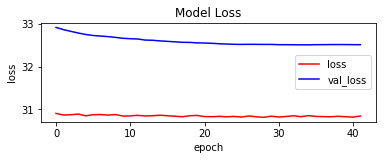

In [219]:
#plot the loss data
plt.subplot(211)
plt.plot(history.history['loss'],'r',label = 'loss')
plt.plot(history.history['val_loss'],'b', label = 'val_loss')
plt.title('Model Loss')
plt.ylabel('loss')
plt.xlabel('epoch')
plt.legend()


In [220]:
#make prediction
# loc_prediction = model.predict(impulses_train)
loc_prediction = model.predict(impulses_test)
print(loc_prediction.shape)
print(location_test.shape)

#The training result
loss = model.evaluate(impulses_test, location_test, verbose=1)
print ('Test loss & mean_absolute_error: ', loss)

(214, 2)
(214, 2)
214/214 [==============================] - 0s 60us/step
Test loss & mean_absolute_error:  30.472253015108198


error distance is  7.298403011148275
max error distance is  12.988032346008843
min error distance is  0.7048226430009379


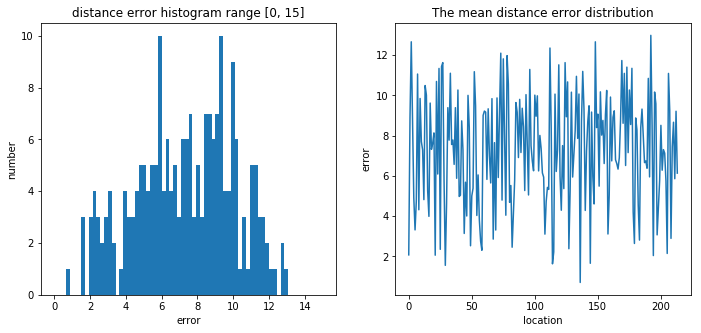

(214, 1)

In [221]:
# calculate the mean of error distance
# err = loc_prediction - location_train
err = loc_prediction - location_test
x = err[:,:1]
y = err[:,1:]

err_dis = np.sqrt(np.square(x)+np.square(y))
err_min = np.min(err_dis)
err_max = np.max(err_dis)
err_avg = np.mean(err_dis)
print("error distance is ", err_avg)
print("max error distance is ", err_max)
print("min error distance is ", err_min)
#set the value of x, y, z
x,y,z = location_test[:,:1],location_test[:,1:2],err_dis

#plot the 2D image of error
plt.figure(figsize=(18,5))
plt.subplot(1,3,1)
plt.hist(err_dis, 70, range = [0, 15])
plt.xlabel("error")
plt.ylabel("number")
plt.title("distance error histogram range [0, 15]") 

# plt.subplot(1,3,2)
# plt.hist(err_dis, 35, range = [0, 50])
# plt.xlabel("error")
# plt.ylabel("number")
# plt.title("distance error histogram range [0, 50]") 


# plt.subplot(1,3,3)
# plt.hist(err_dis, 35, range = [50,230])
# plt.xlabel("error")
# plt.ylabel("number")
# plt.title("distance error histogram range [50, 230]") 
plt.savefig("simu_his.png")

# plt.figure(3)
plt.subplot(1,3,2)
#plt.subplot(2,1,1)
plt.plot(err_dis)
plt.title("The mean distance error distribution")
plt.xlabel("location")
plt.ylabel("error")
plt.show()
x.shape

Text(0.5, 0.92, 'The mean distance error of 3D Iamge')

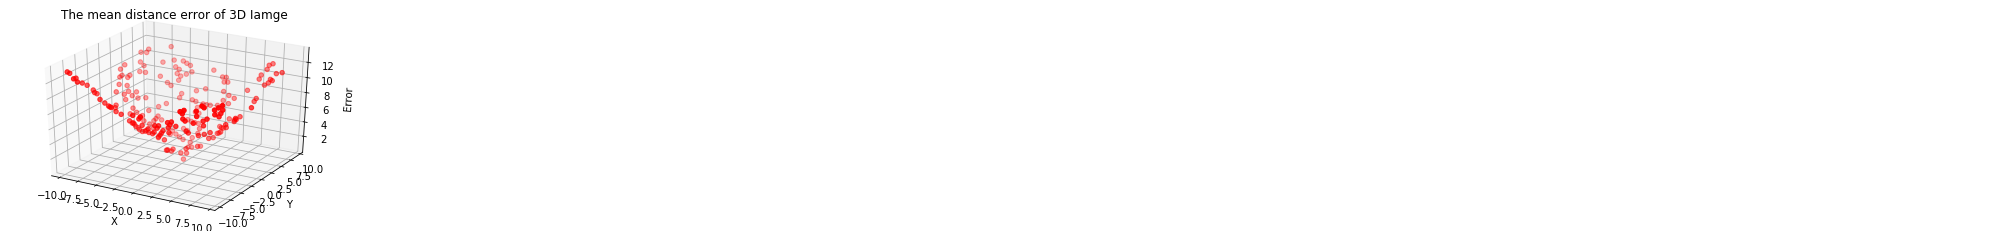

In [209]:
#plot 3D image
ax = plt.subplot(111,projection='3d')
ax.scatter(x,y,z,c='r')
ax.set_xlabel("X")
ax.set_ylabel("Y")
ax.set_zlabel("Error")
plt.title("The mean distance error of 3D Iamge")

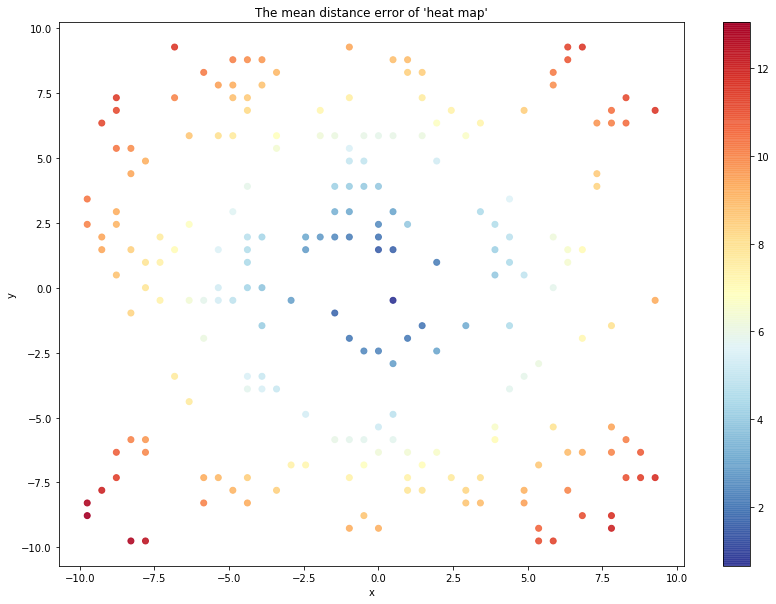

In [210]:
#draw the "heatmap" of error
fig = plt.figure(figsize=(14,10))
ax3 = fig.add_subplot(111)
cm = plt.cm.get_cmap('RdYlBu_r') #Accent  RdYlBu_r RdYlBu  Blues_r  Greens  YlOrBr_r

sc = ax3.scatter(x,y,c = z, marker = 'o', label = 'test',alpha=0.9, cmap=cm)
plt.colorbar(sc)
ax3.set_xlabel("x")
ax3.set_ylabel("y")
plt.title("The mean distance error of 'heat map'")
plt.savefig("heat_map_sim.png")

the mean of error 7.310889
the max of error 13.051189
the max of error 0.651205


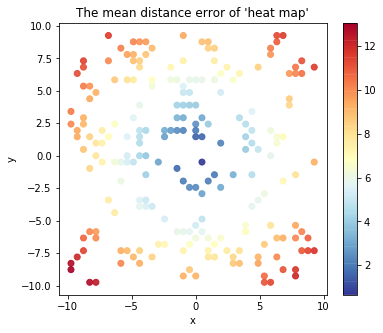

In [211]:
#plot small scale error map

err_map = np.hstack((location_test, err_dis))
err_map = pd.DataFrame(err_map, columns=['x', 'y', 'err'])
err_map_300 = err_map[err_map['x']<300]
err_map_300 = err_map_300[err_map_300['y']<150]
err_map_300 = err_map_300[err_map_300['y']>-150]
# np.array(err_map_300['x'])
print('the mean of error %f'% err_map_300['err'].mean())
print('the max of error %f'% err_map_300['err'].max())
print('the max of error %f'% err_map_300['err'].min())

fig = plt.figure(figsize=(6,5))
ax4 = fig.add_subplot(111)
cm = plt.cm.get_cmap('RdYlBu_r') #Accent  RdYlBu_r RdYlBu  Blues_r  Greens  YlOrBr_r
sc = ax4.scatter(np.array(err_map_300['x']),np.array(err_map_300['y']),c = np.array(err_map_300['err']), marker = 'o', label = 'test',alpha=0.9, cmap=cm)
plt.colorbar(sc)
ax4.set_xlabel("x")
ax4.set_ylabel("y")
plt.title("The mean distance error of 'heat map'")
plt.show()


Text(0.5, 1.0, 'distance error histogram')

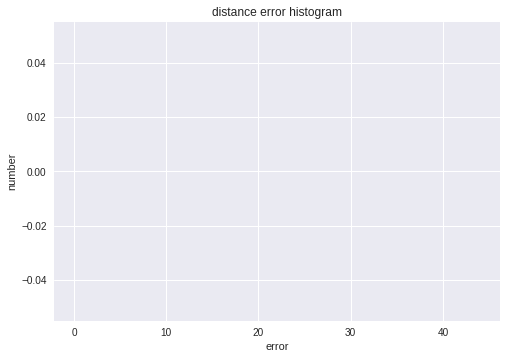

In [52]:

#plot the 2D image of error
plt.figure(1)
#plt.subplot(2,1,2)
plt.hist(np.array(err_map_300['err']), bins =  range(0,45,1)) 
plt.xlabel("error")
plt.ylabel("number")
plt.title("distance error histogram") 

## Conclusion :

number of layers| batch size | epoch | volidation | loss| error(average) | error(min)|
--|--|--|--|--|--|--|
3| 100| 100 | 0.1|1314.788985|22.5|0.23|
4| 100|100|0.1|1273.8396|24.5| 0.12|
batchnormalization 4| 100|100|0.1|overfitting|
batchnormalization 3| 100|100|0.1|82.426|8.4811|0.168|(BEST)
- three layers with mse batch size 100, epoch 100

In [3]:
import scipy.io as sio
import numpy as np
import tensorflow as tf
import keras
import tensorflow as tf
from keras import backend as K
from keras.models import Sequential
from keras.layers import Dense, Dropout, Conv2D, Flatten
from keras.optimizers import RMSprop
import matplotlib.pyplot as plt
#import seaborn as sns; sns.set()
from mpl_toolkits.mplot3d import Axes3D
import pandas as pd
from keras import regularizers
from numpy import linalg as LA

Using TensorFlow backend.


In [4]:
from numpy.random import seed
seed(1)
from tensorflow import set_random_seed
set_random_seed(2)

#loading data
#DDataFile = './data/data_Emre/v_LOS_32_20k.mat'

DDataFile = './3_20_data/qd_LOS_32_3GPPUMi_15k_SC5.mat'

DData = sio.loadmat(DDataFile)
#get the coeff data
h_coeff_all = DData['h_coeff_real']
location = DData['positions']
#split the D_data and location_data and only need the first 2k
N = 15000
M = 32
h_coeff_real = np.array(h_coeff_all[:M,:N])
# print(h_coeff_real[0])
h_coeff_img = np.array(h_coeff_all[M:,:N])
# print(h_coeff_img[0])
h_coeff = h_coeff_real + 1j*h_coeff_img
# print(h_coeff[0])


loc = np.transpose(location[:,:N])
print("h_coeff shape", h_coeff.shape)
print("loc shape", loc.shape)

D = np.asmatrix(np.fft.fft(np.eye(M)/np.sqrt(M)))
DH = D.H
F = np.zeros([N, M, M], dtype = "complex_")

for i in range(N):
    h = np.asmatrix(h_coeff[:, i:i+1])
    v = (M **(1 / 6.0) / LA.norm(h, 2)) **(4/3.) * h
#     hH = h.H
    KK = v * v.H
    B = D * KK * DH
    F[i] = B.A
F = np.asarray(F)
print(F.shape)
print(type(F))


# Do normalization
F = F / np.std(F, axis = 0)

#change the features
# ft = np.real(F)
ft = np.imag(F)
# ft = np.absolute(F) # get the absolute of the F data


print("ft shape", ft.shape, type(ft))

print(F.shape,loc.shape)
total, row, col = F.shape
total, d = loc.shape

train_length = int(np.floor(total * 0.8))

impulses_train = ft[:train_length, :]
location_train = loc[:train_length,:]
print(total,train_length, impulses_train.shape, location_train.shape)

impulses_test = ft[train_length:, :]
location_test = loc[train_length:,:]

# input image dimensions
img_rows, img_cols = 32, 32

if K.image_data_format() == 'channels_first':
    impulses_train = impulses_train.reshape(impulses_train.shape[0], 1, img_rows, img_cols)
    impulses_test = impulses_test.reshape(impulses_test.shape[0], 1, img_rows, img_cols)
    input_shape = (1, img_rows, img_cols)
else:
    impulses_train = impulses_train.reshape(impulses_train.shape[0], img_rows, img_cols, 1)
    impulses_test = impulses_test.reshape(impulses_test.shape[0], img_rows, img_cols, 1)
    input_shape = (img_rows, img_cols, 1)


print('impulses_train shape:', impulses_train.shape)
print('impulses_test shape:', impulses_test.shape)
print(impulses_train.shape[0], 'impulses_train samples')
print(impulses_test.shape[0], 'impulses_test samples')

h_coeff shape (32, 15000)
loc shape (15000, 2)
(15000, 32, 32)
<class 'numpy.ndarray'>
ft shape (15000, 32, 32) <class 'numpy.ndarray'>
(15000, 32, 32) (15000, 2)
15000 12000 (12000, 32, 32) (12000, 2)
impulses_train shape: (12000, 32, 32, 1)
impulses_test shape: (3000, 32, 32, 1)
12000 impulses_train samples
3000 impulses_test samples


In [5]:
#Build the model
model = keras.Sequential()

model.add(keras.layers.Conv2D(32, kernel_size=(8, 8),
                 activation='relu',
                 padding='same',
                 input_shape=input_shape))
# model.add(keras.layers.MaxPooling2D(pool_size=(4, 4), strides=None, padding='valid', data_format=None)) # every layers

# model.add(Dropout(0.4))
# model.add(keras.layers.Conv2D(32, kernel_size=(8, 8),
#                  activation='relu',
#                  padding='same',
#                  input_shape=input_shape))

model.add(Dropout(0.4))
model.add(keras.layers.Conv2D(32, kernel_size=(8, 8),
                 activation='relu',
                 padding='same',
                 input_shape=input_shape))
model.add(keras.layers.MaxPooling2D(pool_size=(4, 4), strides=None, padding='valid', data_format=None)) # every layers

model.add(Dropout(0.4))
model.add(keras.layers.Conv2D(32, kernel_size=(16, 16),
                 activation='relu',
                 padding='same',
                 input_shape=input_shape))
model.add(keras.layers.MaxPooling2D(pool_size=(4, 4), strides=None, padding='valid', data_format=None)) # every layers

model.add(Flatten())

model.add(keras.layers.normalization.BatchNormalization())

model.add(Dropout(0.25))

model.add(Dense(1024, activation = 'tanh'))   #tanh "Bad"  , relu

# model.add(Dense(1024, activation = 'relu'))   #the hidden layer number 

model.add(Dense(512, activation = 'tanh')) 

model.add(Dense(512, activation = 'tanh')) 


model.add(Dense(d, activation = 'linear'))  # None is different from 'linear'      ### Try regularizer layers(l2) weights


#Compilation
def huber_loss(y_true, y_pred):
    return tf.losses.huber_loss(y_true,y_pred)

loss_func = huber_loss  #   categorical_crossentropy(bad)   mean_squared_error
opt_func = keras.optimizers.Adam(lr=0.001) #'Adam'  lr=0.001  #  RMSprop() sgd()  Adadelta()   Adam
callbacks = [keras.callbacks.EarlyStopping(monitor='val_loss', min_delta=0, patience=7, verbose=0, mode='auto', baseline=None, restore_best_weights=True)]

model.compile(loss = loss_func, 
              optimizer = opt_func
             )


print(impulses_train.shape, location_train.shape)


#Train the model, iterating
print(impulses_train.shape, location_train.shape)
print(impulses_test.shape, location_test.shape)

history = model.fit(impulses_train, location_train,
                    batch_size = 100, # 50 -> 52138; 20->52088
                    epochs = 400,
                    verbose = 1,
                    callbacks = callbacks,
                    validation_split = 0.2, #0.2
                    shuffle = True # Try 
#                     validation_data=(impulses_test,location_test)
                   )


Instructions for updating:
Colocations handled automatically by placer.
Instructions for updating:
Please use `rate` instead of `keep_prob`. Rate should be set to `rate = 1 - keep_prob`.
Instructions for updating:
Use tf.cast instead.
(12000, 32, 32, 1) (12000, 2)
(12000, 32, 32, 1) (12000, 2)
(3000, 32, 32, 1) (3000, 2)
Instructions for updating:
Use tf.cast instead.
Train on 9600 samples, validate on 2400 samples
Epoch 1/400
9600/9600 [==============================] - 10s 1000us/step - loss: 197.8061 - val_loss: 180.5908
Epoch 2/400
9600/9600 [==============================] - 4s 380us/step - loss: 164.6093 - val_loss: 150.9706
Epoch 3/400
9600/9600 [==============================] - 4s 379us/step - loss: 135.9242 - val_loss: 122.4266
Epoch 4/400
9600/9600 [==============================] - 4s 377us/step - loss: 107.9287 - val_loss: 94.7402
Epoch 5/400
9600/9600 [==============================] - 4s 378us/step - loss: 80.6113 - val_loss: 67.5485
Epoch 6/400
9600/9600 [==============

(3000, 2)
(3000, 2)
3000/3000 [==============================] - 1s 194us/step
Test loss & mean_absolute_error:  11.211033699035644


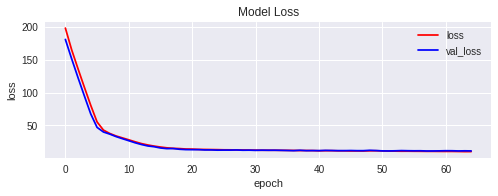

In [6]:
#make prediction
loc_prediction = model.predict(impulses_test)
print(loc_prediction.shape)
print(location_test.shape)

#The training result
loss = model.evaluate(impulses_test, location_test, verbose=1)
print ('Test loss & mean_absolute_error: ', loss)


#plot the loss data
plt.subplot(211)
plt.plot(history.history['loss'],'r',label = 'loss')
plt.plot(history.history['val_loss'],'b', label = 'val_loss')
plt.title('Model Loss')
plt.ylabel('loss')
plt.xlabel('epoch')
plt.legend()


error distance is  19.09227320537101
max error distance is  193.24707834822988
min error distance is  0.007956676992552696


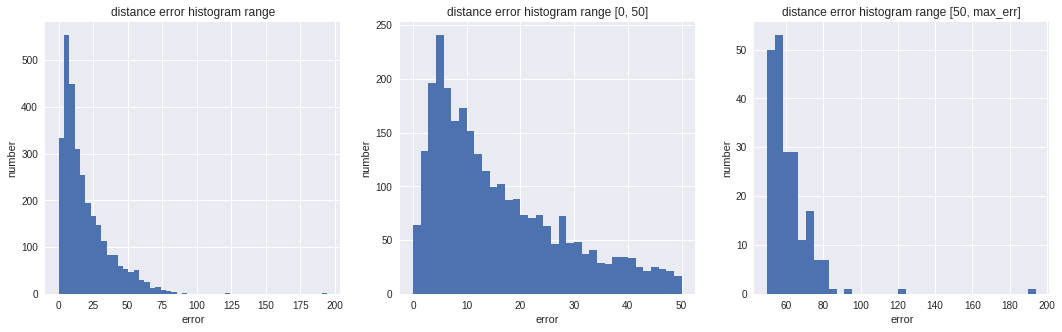

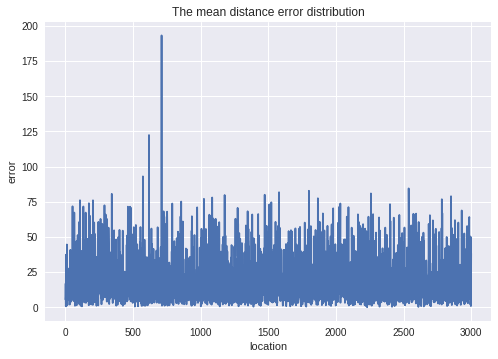

(3000, 1)

In [7]:
#calculate the mean of error distance
err = loc_prediction - location_test
x = err[:,:1]
y = err[:,1:]

err_dis = np.sqrt(np.square(x)+np.square(y))
err_min = np.min(err_dis)
err_max = np.max(err_dis)
err_avg = np.mean(err_dis)
print("error distance is ", err_avg)
print("max error distance is ", err_max)
print("min error distance is ", err_min)
#set the value of x, y, z
x,y,z = location_test[:,:1],location_test[:,1:2],err_dis

#plot the 2D image of error
plt.figure(figsize=(18,5))
plt.subplot(1,3,1)
plt.hist(err_dis, 50, range = [0, err_max + 1])
plt.xlabel("error")
plt.ylabel("number")
plt.title("distance error histogram range") 

plt.subplot(1,3,2)
plt.hist(err_dis, 35, range = [0, 50])
plt.xlabel("error")
plt.ylabel("number")
plt.title("distance error histogram range [0, 50]") 


plt.subplot(1,3,3)
plt.hist(err_dis, 35, range = [50,err_max + 1])
plt.xlabel("error")
plt.ylabel("number")
plt.title("distance error histogram range [50, max_err]") 
plt.savefig("hist.png")

plt.figure(3)
#plt.subplot(2,1,1)
plt.plot(err_dis)
plt.title("The mean distance error distribution")
plt.xlabel("location")
plt.ylabel("error")
plt.show()
x.shape

In [0]:
# 